# K-Means Clustering Model Training

## Import Needed Libraries
* `silhouette_score`
* `calinski_harabasz_score`
* `davies_bouldin_score`

In [1]:
import os, json, itertools
import numpy as np
import pandas as pd
import joblib
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

## Define Constants

In [2]:
ART_DIR = "artifacts"
RANDOM_STATE = 42
ID_COL = "district_id"

### Defining Parameters for Grid Search

* `K_GRID`
* `SEEDS`
* `N_INIT`. In scikit-learn, the `n_init` parameter in the `KMeans` method refers to the number of times the kmeans algorithm is run with different centroid seeds.

In [3]:
K_GRID = range(2, 13)
SEEDS = range(10)
N_INIT = 10

## Helper Functions

In [4]:
def ensure_artifacts_dir():
    os.makedirs(ART_DIR, exist_ok=True)

### Load Feature Matricies

In [5]:

def load_X(variant: str) -> np.ndarray:
    path = f"{ART_DIR}/X_{variant}_scaled.npz"
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Could not find {path}. Run preprocess to produce it."
        )
    arr = np.load(path)
    if "X" not in arr:
        raise KeyError(f"'X' not found in {path}. Check how the array was saved.")
    X = arr["X"]
    if X.ndim != 2:
        raise ValueError(f"X must be 2D (n_samples, n_features). Got shape {X.shape}.")
    return X

### Load Row IDs

In [6]:
def load_ids() -> pd.DataFrame:
    path = f"{ART_DIR}/district_ids.csv"
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Missing {path}. Preprocess should export this file including '{ID_COL}'."
        )
    ids = pd.read_csv(path)
    if ID_COL not in ids.columns:
        raise KeyError(
            f"Expected column '{ID_COL}' in {path}, found {ids.columns.tolist()}"
        )
    if ids[ID_COL].isnull().any():
        raise ValueError("district_ids.csv contains null IDs; fix upstream.")
    if not ids[ID_COL].is_unique:
        raise ValueError("district_ids.csv has duplicate IDs; ensure uniqueness.")
    return ids

## Diagnostics

In [7]:
def print_cluster_sizes(labels: np.ndarray):
    uniq, cnts = np.unique(labels, return_counts=True)
    sizes = dict(zip(uniq.tolist(), cnts.tolist()))
    print("Cluster sizes:", sizes)

## Grid Search
* The `load_X(variant)` helper function is called to load the feature matrix for the selected variant (racial features included vs racial features excluded).
* We iterate through each k and seed and fit Kmeans with n_init restarts, predict labels, and compute Silouette score, Calinski-Harbasz, Davies-Bouldin, and inertia.
* We build a per_fit DataFrame.

In [8]:
def k_search(variant: str, k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT):
    X = load_X(variant)
    if X.shape[0] < max(k_grid):
        raise ValueError(
            f"Need n_samples >= max(k_grid). n_samples={X.shape[0]}, max_k={max(k_grid)}"
        )

    rows = []
    for k, rs in itertools.product(k_grid, seeds):
        km = KMeans(n_clusters=k, random_state=rs, n_init=n_init)
        labels = km.fit_predict(X)
        # Metrics
        try:
            sil = float(silhouette_score(X, labels))
        except Exception:
            sil = float("nan")
        try:
            ch = float(calinski_harabasz_score(X, labels))
        except Exception:
            ch = float("nan")
        try:
            db = float(davies_bouldin_score(X, labels))
        except Exception:
            db = float("nan")
        rows.append({
            "variant": variant,
            "k": int(k),
            "random_state": int(rs),
            "inertia": float(km.inertia_),
            "silhouette": sil,
            "calinski_harabasz": ch,
            "davies_bouldin": db,
            "n_samples": int(X.shape[0]),
            "n_features": int(X.shape[1]),
        })

    df = pd.DataFrame(rows)
    agg = (
        df.groupby("k", as_index=False)
          .agg(
              silhouette_mean=("silhouette", "mean"),
              silhouette_std=("silhouette", "std"),
              ch_mean=("calinski_harabasz", "mean"),
              db_mean=("davies_bouldin", "mean"),
              inertia_mean=("inertia", "mean"),
          )
    )

    agg_sorted = agg.sort_values(
        by=["silhouette_mean", "db_mean", "ch_mean"],
        ascending=[False, True, False]
    ).reset_index(drop=True)

    k_best = int(agg_sorted.iloc[0]["k"]) if len(agg_sorted) else None

    ensure_artifacts_dir()
    out_csv = f"{ART_DIR}/ksearch_{variant}.csv"
    agg_sorted.to_csv(out_csv, index=False)

    print(f"[{variant}] k-search complete. Top k by silhouette: {k_best}")
    print(agg_sorted.head(10))
    return df, agg_sorted, k_best

## Training at Chosen K

In [9]:
def train_variant_with_k(variant: str, k: int):
    ensure_artifacts_dir()
    X = load_X(variant)
    ids = load_ids()

    if len(ids) != X.shape[0]:
        raise ValueError(
            f"Row mismatch: ids={len(ids)} vs X={X.shape[0]}. Ensure preprocess alignment."
        )
    if X.shape[0] <= k:
        raise ValueError(
            f"n_samples={X.shape[0]} must be > k={k}. Lower k or feed finer-grain data."
        )

    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT)
    labels = km.fit_predict(X)

    model_path = f"{ART_DIR}/kmeans_{variant}_k{k}.joblib"
    joblib.dump(km, model_path)

    out_labels_path = f"{ART_DIR}/clusters_{variant}_k{k}.csv"
    out_ids = ids.copy()
    out_ids[f"cluster_{variant}_k{k}"] = labels
    out_ids.to_csv(out_labels_path, index=False)

    inertia = float(km.inertia_)
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = float("nan")

    meta = {
        "variant": variant,
        "k": int(k),
        "random_state": int(RANDOM_STATE),
        "n_init": str(N_INIT),
        "inertia": inertia,
        "silhouette": sil,
        "n_samples": int(X.shape[0]),
        "n_features": int(X.shape[1]),
        "ids_file": f"{ART_DIR}/district_ids.csv",
        "X_file": f"{ART_DIR}/X_{variant}_scaled.npz",
        "model_file": model_path,
        "labels_file": out_labels_path,
        "id_col": ID_COL,
    }
    with open(f"{ART_DIR}/trainmeta_{variant}_k{k}.json", "w") as f:
        json.dump(meta, f, indent=2)

    print(f"[{variant}] k={k} | inertia={inertia:.3f} | silhouette={sil if sil==sil else 'NA'} | X={X.shape}")
    print_cluster_sizes(labels)

    return km, labels, meta

## Run End-to-End

### Search Over k for Both Variants

In [10]:
_, full_agg, k_full = k_search("full", k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT)
_, norace_agg, k_norace = k_search("norace", k_grid=K_GRID, seeds=SEEDS, n_init=N_INIT)



[full] k-search complete. Top k by silhouette: 2
    k  silhouette_mean  silhouette_std    ch_mean   db_mean  inertia_mean
0   2         0.278885        0.013447  12.769573  1.533542    280.503303
1   5         0.268764        0.010173  13.311987  1.079019    145.421509
2   3         0.261740        0.008347  13.665936  1.207781    213.376353
3   4         0.261609        0.011047  13.760812  1.130567    171.654075
4   7         0.240199        0.025085  12.023576  1.009994    114.236716
5   8         0.232433        0.013881  12.218731  1.001297     98.697581
6  10         0.229483        0.008875  12.359705  0.902264     76.455827
7   9         0.229097        0.006515  12.437709  0.970652     85.809211
8   6         0.228173        0.033349  12.354419  1.125663    129.708153
9  11         0.226018        0.011085  12.045115  0.870723     69.623613
[norace] k-search complete. Top k by silhouette: 10
    k  silhouette_mean  silhouette_std    ch_mean   db_mean  inertia_mean
0  10      

### Train Final Models at Chosen k

In [11]:
km_full, labels_full, meta_full = train_variant_with_k("full", k_full)
km_norace, labels_norace, meta_norace = train_variant_with_k("norace", k_norace)

[full] k=2 | inertia=280.374 | silhouette=0.2831376329426156 | X=(38, 10)
Cluster sizes: {0: 13, 1: 25}
[norace] k=10 | inertia=25.544 | silhouette=0.36929174706501755 | X=(38, 6)
Cluster sizes: {0: 7, 1: 9, 2: 2, 3: 2, 4: 2, 5: 5, 6: 2, 7: 1, 8: 2, 9: 6}


### PCA Scatter
For deeper visuals, use the evaluate notebook.
PCA scatter is done for a quick visual separation check

2025-12-03 10:42:41.744 | INFO     | texas_gerrymandering_hb4.config:<module>:11 - PROJ_ROOT path is: /home/algorithmicprogrammer/Documents/texas-gerrymandering-hb4


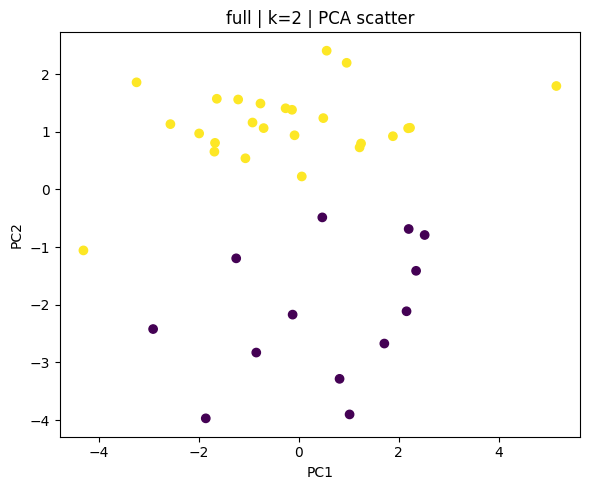

[visuals] Saved PCA scatter to: /home/algorithmicprogrammer/Documents/texas-gerrymandering-hb4/reports/figures/kmeans_pca_full_k2.eps


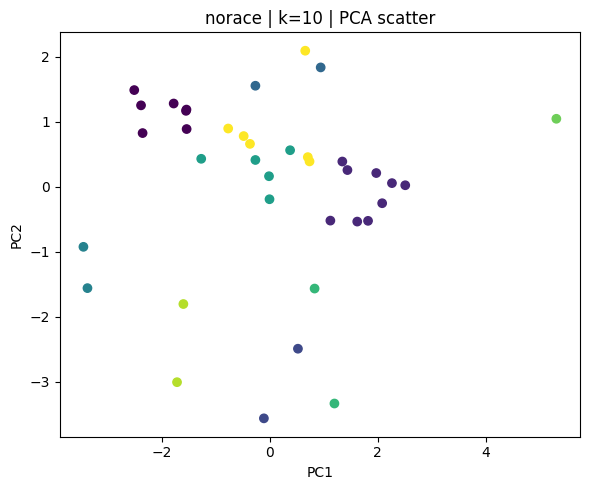

[visuals] Saved PCA scatter to: /home/algorithmicprogrammer/Documents/texas-gerrymandering-hb4/reports/figures/kmeans_pca_norace_k10.eps


In [12]:
try:
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    from texas_gerrymandering_hb4.config import FIGURES_DIR


    def plot_pca_scatter(X, labels, title, filename):
        p = PCA(n_components=2).fit_transform(X)
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.scatter(p[:, 0], p[:, 1], c=labels)
        ax.set_title(title)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        fig.tight_layout()
        output_path = FIGURES_DIR / filename
        fig.savefig(output_path, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close(fig)
        print(f"[visuals] Saved PCA scatter to: {output_path}")

    # full
    X_full = load_X("full")
    plot_pca_scatter(
        X_full,
        labels_full,
        title=f"full | k={k_full} | PCA scatter",
        filename=f"kmeans_pca_full_k{k_full}.eps",
    )

    # norace
    X_nr = load_X("norace")
    plot_pca_scatter(
        X_nr,
        labels_norace,
        title=f"norace | k={k_norace} | PCA scatter",
        filename=f"kmeans_pca_norace_k{k_norace}.eps",
    )
except Exception as e:
    print("[visuals] Skipped PCA scatter:", e)

